In [1]:
from google.colab import files
uploaded = files.upload()


Saving COMED_hourly.csv to COMED_hourly.csv


In [0]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import plotly.express as px
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sklearn.preprocessing
import tensorflow as tf
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

%matplotlib inline

df = pd.read_csv(io.BytesIO(uploaded['COMED_hourly.csv']), index_col=[0], parse_dates=[0])


df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month 
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour 
df['woy'] = df.index.weekofyear
df['dom'] = df.index.day
df['season'] = df['month'].apply(lambda month_number: (month_number%12 + 3)//3)
df = df.rename(columns={'COMED_MW':'Useage'})
scaler = sklearn.preprocessing.MinMaxScaler()
df['Useage']=scaler.fit_transform(df['Useage'].values.reshape(-1,1))
  


In [256]:
df.describe

<bound method NDFrame.describe of                        Useage  dow  doy  year  ...  hour  woy  dom  season
Datetime                                       ...                        
2011-12-31 01:00:00  0.165476    5  365  2011  ...     1   52   31       1
2011-12-31 02:00:00  0.132659    5  365  2011  ...     2   52   31       1
2011-12-31 03:00:00  0.110317    5  365  2011  ...     3   52   31       1
2011-12-31 04:00:00  0.095665    5  365  2011  ...     4   52   31       1
2011-12-31 05:00:00  0.091184    5  365  2011  ...     5   52   31       1
...                       ...  ...  ...   ...  ...   ...  ...  ...     ...
2018-01-01 20:00:00  0.400884    0    1  2018  ...    20    1    1       1
2018-01-01 21:00:00  0.394829    0    1  2018  ...    21    1    1       1
2018-01-01 22:00:00  0.386898    0    1  2018  ...    22    1    1       1
2018-01-01 23:00:00  0.369278    0    1  2018  ...    23    1    1       1
2018-01-02 00:00:00  0.337794    1    2  2018  ...     0    1    2

Split data into train/test sets

In [242]:
cutoff = pd.to_datetime('2017-01-01')

# splitting
train = df.loc[df.index <= cutoff].copy()
test = df.loc[df.index > cutoff].copy()
print(f'Training shape: {train.shape} \nTesting shape: {test.shape}\n')
print(f'The training set lies between the dates: {min(train.index)} and {max(train.index)}')
print(f'For the testing set, the dates are: {min(test.index)} and {max(test.index)}')

Training shape: (52602, 10) 
Testing shape: (13895, 10)

The training set lies between the dates: 2011-01-01 01:00:00 and 2017-01-01 00:00:00
For the testing set, the dates are: 2017-01-01 01:00:00 and 2018-08-03 00:00:00


In [0]:
def create_features(df, label=None):
  x = df[['Useage', 'dow', 'doy', 'year', 'month', 'quarter', 'hour', 'woy', 'dom', 'season']]
  if label:
    y = df[label]
    return x,y
  return x

x_train, y_train = create_features(train, label='Useage')
x_test, y_test = create_features(test, label='Useage')

First Model: XGBoost

In [244]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
reg = xgb.XGBRegressor(n_estimators=300)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[21:16:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

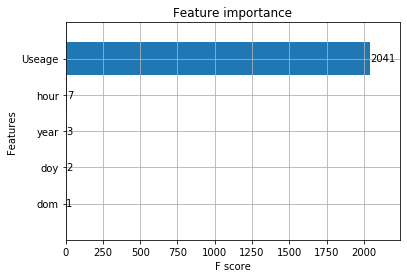

In [245]:
_ = plot_importance(reg, height=0.9)

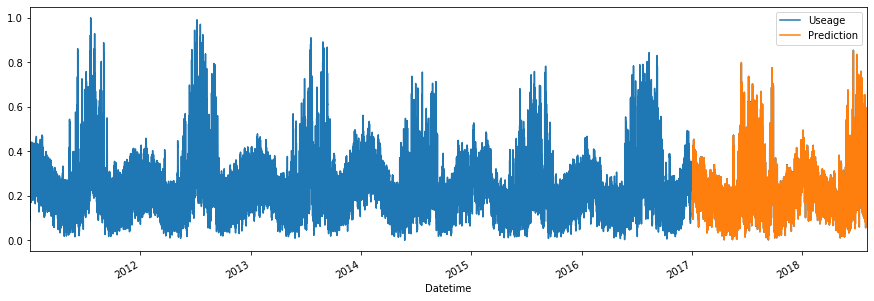

In [246]:
test['Prediction'] = reg.predict(x_test)
full_df = pd.concat([test, train], sort=False)
_ = full_df[['Useage', 'Prediction']].plot(figsize=(15,5))

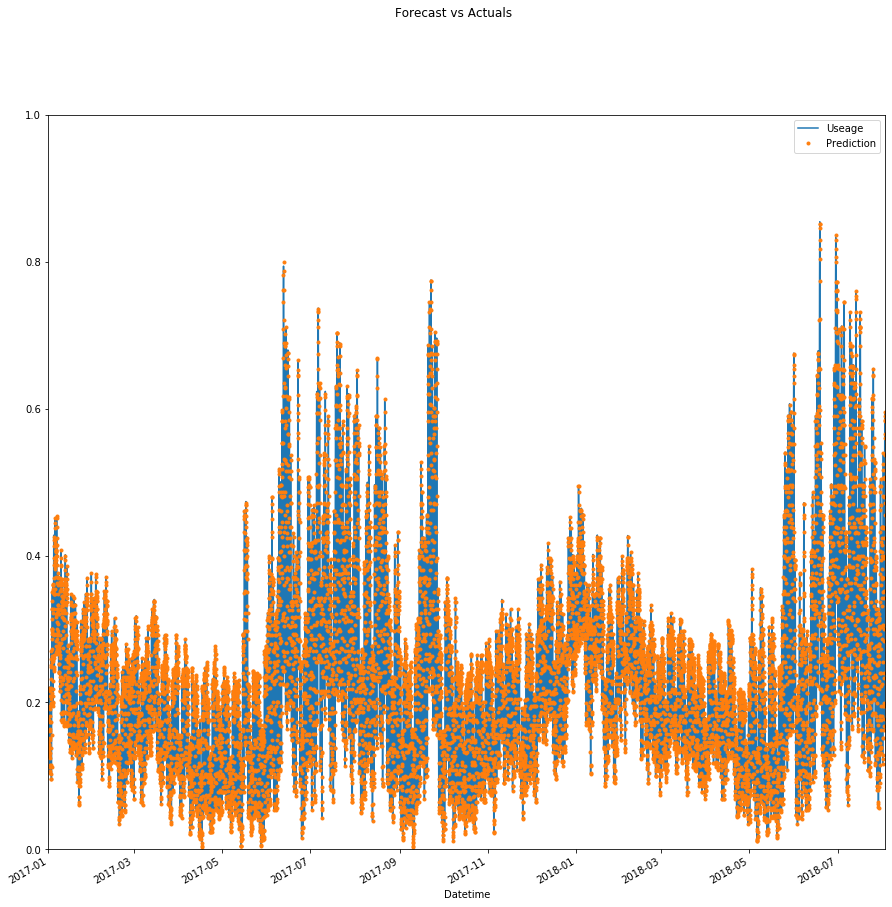

In [254]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(15)
f.set_figwidth(15)
_ = full_df[['Useage','Prediction']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2017-01-01', upper='2018-08-03')
ax.set_ylim(0, 1)
plot = plt.suptitle('Forecast vs Actuals')

In [249]:
mean_squared_error(y_true=test['Useage'],
                   y_pred=test['Prediction'])

8.162353763496384e-07

In [252]:
mean_absolute_error(y_true=test['Useage'],
                   y_pred=test['Prediction'])

0.0006865094923255324

Second Model: RNN

In [259]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[63172:]             
    y_test = y_train[63172:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:63172]           
    y_train = y_train[:63172]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (63172, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

X_train.shape =  (63172, 20, 1)
y_train.shape =  (63172,)
X_test.shape =  (3305, 20, 1)
y_test.shape =  (3305,)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3240      
_____________________

In [260]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9591147646489555


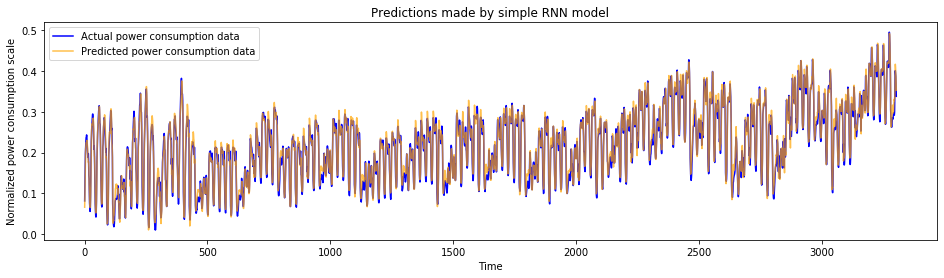

In [261]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")